# Google Landmark 2019

References:
4th place solution last year
https://www.kaggle.com/c/landmark-recognition-challenge/discussion/57896#latest-418704

Compressed and resized training and test images
https://www.kaggle.com/c/landmark-recognition-2019/discussion/91770#latest-532165

https://www.kaggle.com/c/landmark-recognition-2019/discussion/90346#latest-532193

EDA and loading data
https://www.kaggle.com/mayukh18/dataset-exploration-and-simple-on-the-fly-training



Plan

1. bring in training images that have >K examples for each class.  K=10
2. Train resnet34 on this and see xval score (basic classification)
3. Understand how to measure the metric being optimized in the contest
4. develop a heuristic/trained approach for submitting results

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import torch


In [3]:
from smtplib import SMTP_SSL as SMTP
from email.mime.text import MIMEText
def send_txt(subject, body, toaddr="6519834115@tmomail.net"):
    fromaddr = "thebignotifier@gmail.com"
    msg = MIMEText(body, 'plain')
    msg['To'] = toaddr
    msg['Subject'] = subject

    server = SMTP('smtp.gmail.com')
    server.login(fromaddr, "eatbzltjueqfdopg")
    server.sendmail(fromaddr, toaddr, msg.as_string())
    server.quit()

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [4]:
bs = 200
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
num_workers = 5

In [5]:
path=Path("/media/SSD/data_google_landmark_recog_2019")
path.ls()

[PosixPath('/media/SSD/data_google_landmark_recog_2019/Stage2'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train.csv.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/test.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/submission7.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/recognition_sample_submission.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256.tar'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/data_import.sh'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/Stage1'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/boxes_split1.csv.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/test_256-2'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/boxes_split2.csv.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/submission5.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2

In [6]:
path_img = path / 'train-256'
path_img

PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256')

## Looking at the data

In [7]:
train = pd.read_csv(path / "train.csv")
print(train.head())
print(train.shape)
print("Number of classes {}".format(len(train.landmark_id.unique())))


                 id                                                url  \
0  6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   
1  202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
2  3ad87684c99c06e1  http://upload.wikimedia.org/wikipedia/commons/...   
3  e7f70e9c61e66af3  https://upload.wikimedia.org/wikipedia/commons...   
4  4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   

   landmark_id  
0       142820  
1       104169  
2        37914  
3       102140  
4         2474  
(4132914, 3)
Number of classes 203094


In [8]:
files = os.listdir(path_img)

In [9]:
#file_jpg = [k for k in files if '.jpg' in k]

In [10]:

#file_dict = {clean_string(x) : x for x in files if '.jpg' in x}


In [11]:
#get all the files in the image directory and drop the ''.jpg' of the filename to get the 'id' of the image
def clean_string (x):
    return x[:-4]

#lst = set(map(clean_string,os.listdir(path_img)))
lst = set([clean_string(x) for x in files if '.jpg' in x])

In [12]:
# select image ids that have image files
lst3 = [value[0] for value in zip(train.index, train['id']) if value[1] in lst]
train2=train.loc[lst3]

In [13]:
K=100
counts = dict(Counter(train2['landmark_id']))
landmarks_dict = {x:[] for x in train2.landmark_id.unique() if (counts[x] >= K)}
NUM_CLASSES = len(landmarks_dict)
print("Total number of valid classes: {}".format(NUM_CLASSES))

Total number of valid classes: 6513


In [14]:
new_train = train2[train2['landmark_id'].isin(landmarks_dict)].copy()
print(new_train.head())
print(new_train.shape)
print("Number of classes {}".format(len(new_train.landmark_id.unique())))

                  id                                                url  \
1   202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
4   4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   
6   6f31b874d1a4d489  https://upload.wikimedia.org/wikipedia/commons...   
9   8df019949b8db328  https://upload.wikimedia.org/wikipedia/commons...   
11  ccf070a2da242d56  https://upload.wikimedia.org/wikipedia/commons...   

    landmark_id  
1        104169  
4          2474  
6          6888  
9         81049  
11       138982  
(1263760, 3)
Number of classes 6513


In [15]:
del train2,train, lst, files, lst3, counts, landmarks_dict

In [16]:
learn=None
gc.collect()
torch.cuda.empty_cache()

In [17]:
#data = ImageDataBunch.from_df(path_img, new_train, fn_col="id", label_col="landmark_id", suffix='.jpg', ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)
#np.random.seed(42)
data = ImageDataBunch.from_df(path_img, new_train, fn_col="id", label_col="landmark_id", suffix='.jpg',
                              ds_tfms=get_transforms(), size=224, bs=bs,
                              num_workers=num_workers).normalize(imagenet_stats)


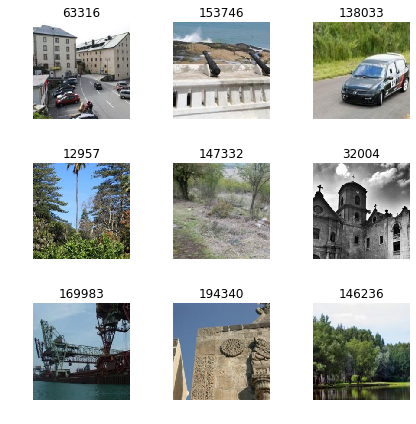

In [18]:
data.show_batch(rows=3, figsize=(6,6))

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [18]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate).to_fp16()
#learn = cnn_learner(data, models.resnet34, metrics=error_rate).TTA()

## Clean the data for outliers based on best model so far

In [19]:
learn.load('stage-4');

In [20]:
learn.to_fp32()

Learner(data=ImageDataBunch;

Train: LabelList (1011008 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
104169,2474,6888,81049,138982
Path: /media/SSD/data_google_landmark_recog_2019/train-256;

Valid: LabelList (252752 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
41808,29060,42123,91090,190948
Path: /media/SSD/data_google_landmark_recog_2019/train-256;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)


True

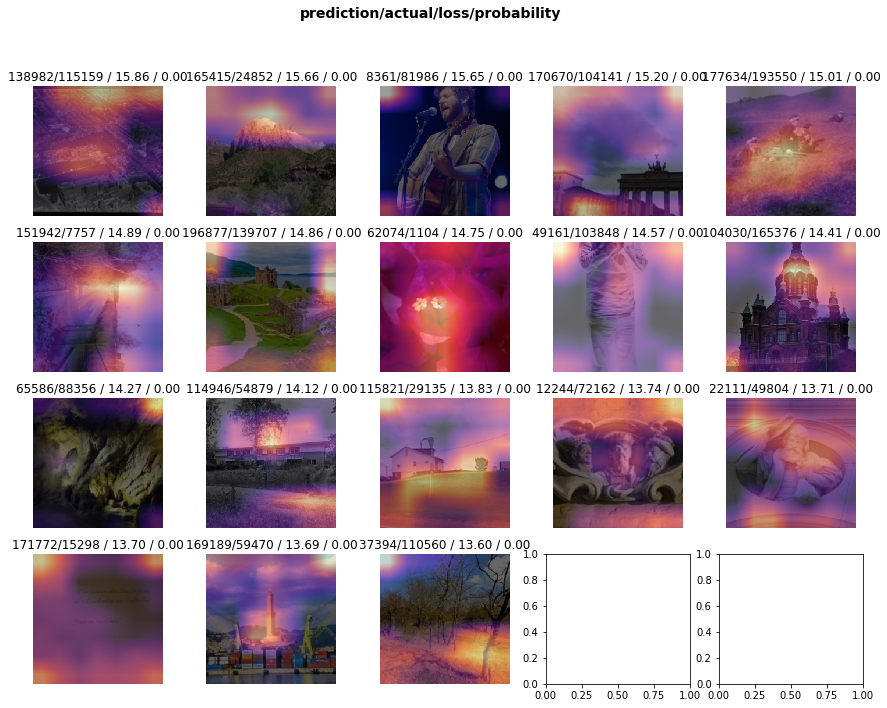

In [22]:
interp.plot_top_losses(18, figsize=(15,11))

In [92]:
top_loss_paths = data.train_ds.x[idxs]


In [110]:
import os

In [93]:
id=-1

1001 /media/SSD/data_google_landmark_recog_2019/train-256/ede2dfdb97402267.jpg


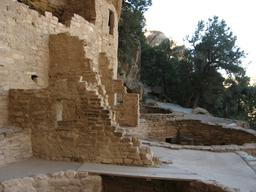

In [1308]:
id=id+1
p=Path(top_loss_paths.items[id])
print(id, p)
top_loss_paths.get(id)


In [1297]:
os.remove(p)

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [5]:
path=Path("/media/SSD/data_google_landmark_recog_2019")
path.ls()

[PosixPath('/media/SSD/data_google_landmark_recog_2019/Stage2'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train.csv.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/test.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/submission7.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/recognition_sample_submission.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256.tar'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/data_import.sh'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/Stage1'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/boxes_split1.csv.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/test_256-2'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/boxes_split2.csv.zip'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256'),
 PosixPath('/media/SSD/data_google_landmark_recog_2019/submission5.csv'),
 PosixPath('/media/SSD/data_google_landmark_recog_2

In [6]:
path_img = path / 'train-256'
path_img

PosixPath('/media/SSD/data_google_landmark_recog_2019/train-256')

## Looking at the data

In [7]:
train = pd.read_csv(path / "train.csv")
print(train.head())
print(train.shape)
print("Number of classes {}".format(len(train.landmark_id.unique())))


                 id                                                url  \
0  6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   
1  202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
2  3ad87684c99c06e1  http://upload.wikimedia.org/wikipedia/commons/...   
3  e7f70e9c61e66af3  https://upload.wikimedia.org/wikipedia/commons...   
4  4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   

   landmark_id  
0       142820  
1       104169  
2        37914  
3       102140  
4         2474  
(4132914, 3)
Number of classes 203094


In [8]:
files = os.listdir(path_img)

In [9]:
#file_jpg = [k for k in files if '.jpg' in k]

In [10]:

#file_dict = {clean_string(x) : x for x in files if '.jpg' in x}


In [11]:
#get all the files in the image directory and drop the ''.jpg' of the filename to get the 'id' of the image
def clean_string (x):
    return x[:-4]

#lst = set(map(clean_string,os.listdir(path_img)))
lst = set([clean_string(x) for x in files if '.jpg' in x])

In [12]:
# select image ids that have image files
lst3 = [value[0] for value in zip(train.index, train['id']) if value[1] in lst]
train2=train.loc[lst3]

In [13]:
K=150
counts = dict(Counter(train2['landmark_id']))
landmarks_dict = {x:[] for x in train2.landmark_id.unique() if (counts[x] >= K)}
NUM_CLASSES = len(landmarks_dict)
print("Total number of valid classes: {}".format(NUM_CLASSES))

Total number of valid classes: 3060


In [14]:
new_train = train2[train2['landmark_id'].isin(landmarks_dict)].copy()
print(new_train.head())
print(new_train.shape)
print("Number of classes {}".format(len(new_train.landmark_id.unique())))

                  id                                                url  \
1   202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
4   4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   
6   6f31b874d1a4d489  https://upload.wikimedia.org/wikipedia/commons...   
9   8df019949b8db328  https://upload.wikimedia.org/wikipedia/commons...   
11  ccf070a2da242d56  https://upload.wikimedia.org/wikipedia/commons...   

    landmark_id  
1        104169  
4          2474  
6          6888  
9         81049  
11       138982  
(847335, 3)
Number of classes 3060


In [15]:
del train2,train, lst, files, lst3, counts, landmarks_dict

In [16]:
learn=None
gc.collect()
torch.cuda.empty_cache()

In [17]:
#data = ImageDataBunch.from_df(path_img, new_train, fn_col="id", label_col="landmark_id", suffix='.jpg', ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)
#np.random.seed(42)
data = ImageDataBunch.from_df(path_img, new_train, fn_col="id", label_col="landmark_id", suffix='.jpg',
                              ds_tfms=get_transforms(), size=224, bs=bs,
                              num_workers=num_workers).normalize(imagenet_stats)


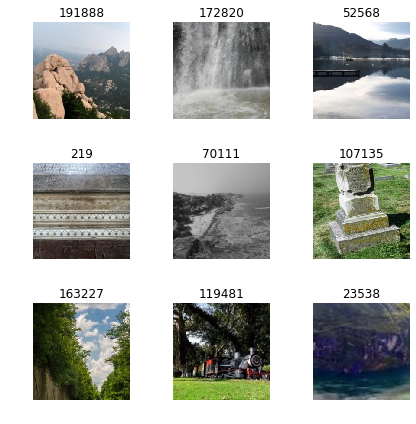

In [18]:
data.show_batch(rows=3, figsize=(6,6))

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [21]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate).to_fp16()
#learn = cnn_learner(data, models.resnet34, metrics=error_rate).TTA()

## fit output layer

In [22]:
learn.freeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,5.171412,4.572266,0.775366,24:55
1,4.677225,3.959233,0.689780,24:42
2,4.408404,3.675794,0.648162,24:51


In [23]:
learn.freeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,4.442663,3.732487,0.654889,24:54


In [24]:
learn.save('res34-clean-stage-1')

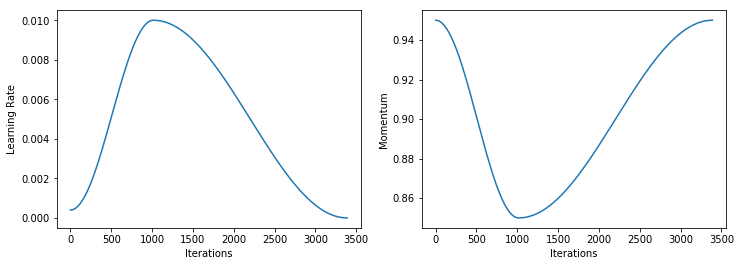

In [25]:
learn.recorder.plot_lr(show_moms=True)

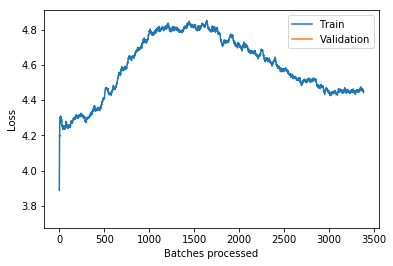

In [26]:
learn.recorder.plot_losses()

Min numerical gradient: 4.05E-04


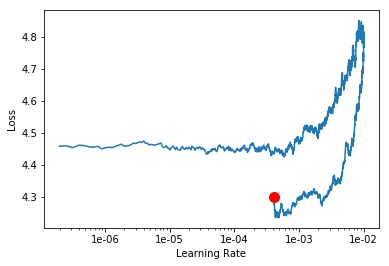

In [27]:
learn.recorder.plot(suggestion=True)

In [28]:
send_txt("!!","stage1 complete")

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [29]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,4.025504,3.402583,0.614515,27:50
1,3.749503,3.102042,0.570949,27:50
2,3.490197,2.920361,0.539999,27:55
3,3.389908,2.872068,0.533089,27:52


In [30]:
learn.save('res34-clean-stage-2')

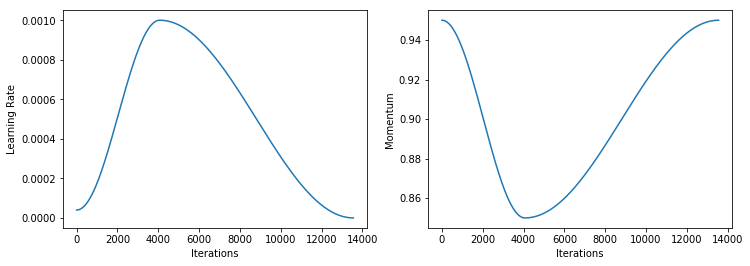

In [31]:
learn.recorder.plot_lr(show_moms=True)

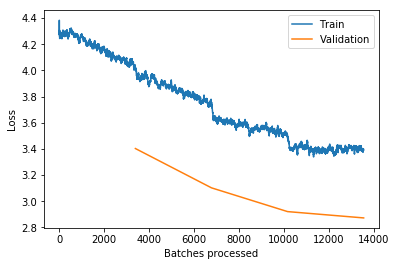

In [32]:
learn.recorder.plot_losses()

Min numerical gradient: 4.00E-05


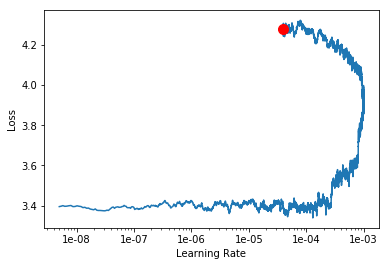

In [33]:
learn.recorder.plot(suggestion=True)

In [34]:
send_txt("!!","stage2 complete")

In [41]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,3.406849,2.880860,0.535591,28:05
1,3.388179,2.817338,0.527383,27:44
2,3.259051,2.692179,0.507072,27:47
3,3.086364,2.595568,0.490166,27:51
4,2.970263,2.569190,0.484590,27:50


In [42]:
learn.save('res34-clean-stage-3')

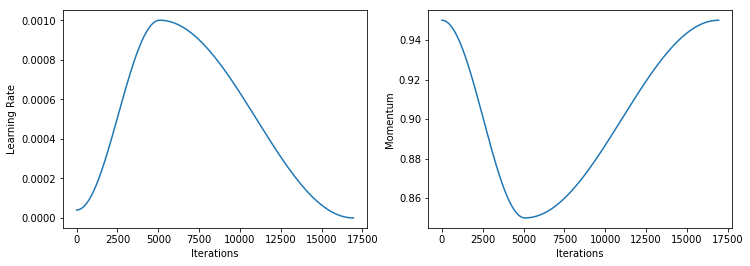

In [43]:
learn.recorder.plot_lr(show_moms=True)

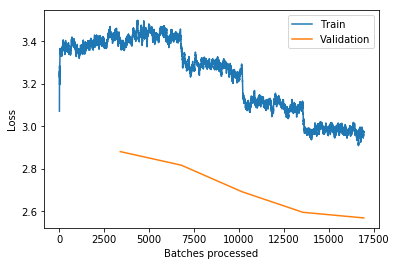

In [44]:
learn.recorder.plot_losses()

Min numerical gradient: 4.00E-05


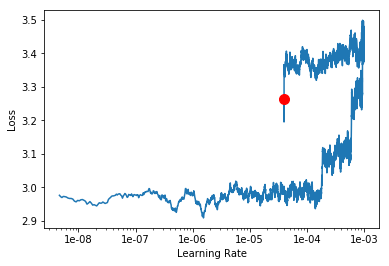

In [45]:
learn.recorder.plot(suggestion=True)

In [46]:
send_txt("!!","stage3 complete")

In [47]:
learn.fit(20, lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,4.101029,3.519403,0.636537,27:39
1,3.772021,3.183817,0.586232,27:43
2,3.589513,3.033676,0.562859,27:46
3,3.402039,2.874591,0.541445,27:45
4,3.282696,2.801646,0.530510,27:50
5,3.216720,2.726954,0.516095,27:50
6,3.109867,2.689574,0.510748,27:45
7,3.077811,2.666984,0.506978,27:43
8,2.988779,2.636433,0.500823,27:47
9,2.960247,2.565237,0.489653,27:52


In [48]:
learn.save('res34-clean-stage-4')

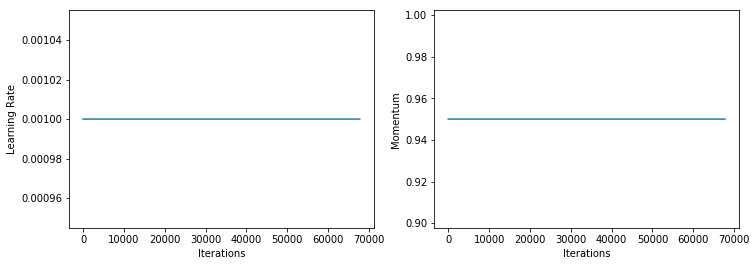

In [49]:
learn.recorder.plot_lr(show_moms=True)

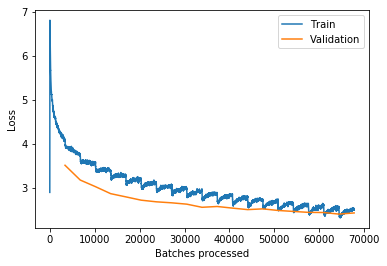

In [50]:
learn.recorder.plot_losses()

Min numerical gradient: 1.00E-03


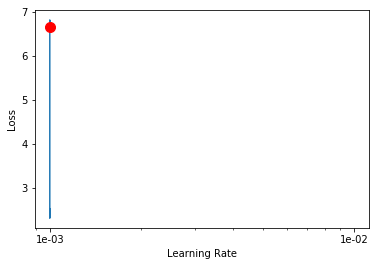

In [51]:
learn.recorder.plot(suggestion=True)

In [52]:
send_txt("!!","stage4 complete")

# Predict test set

In [53]:
#export model and other contains everything we need to deploy our model 
#(the model, the weights but also some metadata like the classes or the transforms/normalization used).
learn.export("export.pkl")

#to load it
#learn = load_learner(path)


In [54]:
# path to test set
path_test = path / 'test_256-2/test'
path_test

PosixPath('/media/SSD/data_google_landmark_recog_2019/test_256-2/test')

In [55]:
# load submission
submission = pd.read_csv(path / 'recognition_sample_submission.csv', index_col='id')


In [56]:
# predict test set
#from fastprogress import master_bar, progress_bar

for fn in progress_bar(submission.index):
    try:
        img = open_image(path_test / (fn + '.jpg'))
    except:
        #print("file not found:"+ fn + '.jpg')
        submission.loc[fn]=""
    else:
        pred_class,pred_idx,outputs = learn.predict(img)
        #print(pred_class, pred_idx,outputs[pred_idx])
        submission.loc[fn]=str(pred_class)+ " "+ str(outputs[pred_idx].item())
submission[0:20]
    

,landmarks
id,
cc4e1335111d0f14,151942 0.1540738344192505
75f7113a26d670d9,142644 0.16029781103134155
3eeb10b0aa3cfbff,59546 0.4300682544708252
cefe5f969b9d4324,174697 0.664046585559845
9324ef326508dda3,174911 0.1544973999261856
fa8a341223e53b45,72303 0.21791104972362518
a0b3a793f1b8e5c1,80177 0.6693821549415588
a4bbe52b528c33a4,164562 0.14664675295352936
7ab6befcb914f4f0,30532 0.04483773559331894


In [57]:
submission.to_csv(path / 'submission9.csv',index=True)

In [58]:
send_txt("!!","pred complete")